In [1]:
from google.colab import drive
drive.mount('/content/drive')

import cv2
import numpy as np
import pandas as pd
import os
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow.keras as K
import tensorflow.keras.backend as Kback
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf

Mounted at /content/drive


# Loading dataset for testing

In [2]:
test_datagen = K.preprocessing.image.ImageDataGenerator(rescale = 1./255)   

test_dataset  = test_datagen.flow_from_directory(directory = '/content/drive/MyDrive/Test',
                                                   target_size = (160,160),
                                                   class_mode = 'categorical',
                                                   subset = 'training',
                                                   shuffle=False,
                                                   batch_size = 64)

Found 20010 images belonging to 20 classes.


# The three best models for voting (snapshot 1,2 and DenseNet121_CBAM)

In [3]:
def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = Kback.sum(Kback.round(Kback.clip(y_true * y_pred, 0, 1)))
    possible_positives = Kback.sum(Kback.round(Kback.clip(y_true, 0, 1)))
    predicted_positives = Kback.sum(Kback.round(Kback.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + Kback.epsilon())
    recall = true_positives / (possible_positives + Kback.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+Kback.epsilon())
    return f1_val

model0 = K.models.load_model("/content/drive/MyDrive/Colab Notebooks/snapshot_model_2.h5", custom_objects={"f1_score": f1_score})
model1 = K.models.load_model("/content/drive/MyDrive/Colab Notebooks/snapshot_model_1.h5", custom_objects={"f1_score": f1_score})
model2 = K.models.load_model("/content/drive/MyDrive/Colab Notebooks/snapshot_model_4.h5", custom_objects={"f1_score": f1_score})
#model0 = K.models.load_model("/content/drive/MyDrive/Colab Notebooks/snapshot_model_2.h5", custom_objects={"f1_score": f1_score})
#model1 = K.models.load_model("/content/drive/MyDrive/Colab Notebooks/snapshot_model_3.h5", custom_objects={"f1_score": f1_score})
#model2 = K.models.load_model("/content/drive/MyDrive/Colab Notebooks/snapshot_model_4.h5", custom_objects={"f1_score": f1_score})
# model3 = K.models.load_model("/content/drive/MyDrive/Colab Notebooks/snapshot_model_5.h5", custom_objects={"f1_score": f1_score})
# model4 = K.models.load_model("/content/drive/MyDrive/Colab Notebooks/snapshot_model_1.h5", custom_objects={"f1_score": f1_score})
#model_cbam = K.models.load_model("densenet121_cbam.hdf5", custom_objects={"f1_score": f1_score})

In [4]:
y_label = np.asarray(test_dataset.classes)
y_label = y_label.astype('int')

Y_pred_0 = model0.predict_generator(test_dataset, 1157)
y_pred_0 = np.argmax(Y_pred_0, axis=1)
y_pred_0 = y_pred_0.astype('int')

Y_pred_1 = model1.predict_generator(test_dataset, 1157)
y_pred_1 = np.argmax(Y_pred_1, axis=1)
y_pred_1 = y_pred_1.astype('int')

Y_pred_2 = model2.predict_generator(test_dataset, 1157)
y_pred_2 = np.argmax(Y_pred_2, axis=1)
y_pred_2 = y_pred_2.astype('int')

# Y_pred_3 = model3.predict_generator(test_dataset, 1157)
# y_pred_3 = np.argmax(Y_pred_3, axis=1)
# y_pred_3 = y_pred_3.astype('int')

# Y_pred_4 = model4.predict_generator(test_dataset, 1157)
# y_pred_4 = np.argmax(Y_pred_4, axis=1)
# y_pred_4 = y_pred_4.astype('int')

<ipython-input-4-cad4f194d121>:4: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred_0 = model0.predict_generator(test_dataset, 1157)
<ipython-input-4-cad4f194d121>:8: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred_1 = model1.predict_generator(test_dataset, 1157)
<ipython-input-4-cad4f194d121>:12: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred_2 = model2.predict_generator(test_dataset, 1157)


In [5]:
#Y_pred_cbam = model0.predict_generator(test_dataset, 1157)
#y_pred_cbam = np.argmax(Y_pred_cbam, axis=1)
#y_pred_cbam = y_pred_cbam.astype('int')

#### Max Voting

In [32]:
def voting_max(arr1,arr2,arr3):
    arr = []
    for i in range(0,20010):
        if arr1[i] == arr2[i] or arr1[i] == arr3[i] or arr1[i] == arr2[i] == arr3[i]:
            arr.append(arr1[i])
        elif arr2[i] == arr3[i]:
            arr.append(arr2[i])
        else:
            arr.append(arr1[i])
    arr = np.asarray(arr)
    arr = arr.astype('int')
    return arr

#### Weighted voting 

In [31]:
def voting_weighted(arr1,arr2,arr3):
    arr = []
    for i in range(0,20010):
        arr.append(0.4*arr1[i]+0.3*arr2[i]+0.3*arr3[i])
    arr = np.asarray(arr)
    arr = arr.astype('int')
    return arr

#### Groupwise weighted voting

In [8]:
def voting_group_weighted(arr1,arr2,arr3,arr4,arr5):
    arr = []
    for i in range(0,2000):
        a = 0.4*arr1[i]+(0.2*arr2[i]+0.1*arr5[i])+(0.2*arr3[i]+0.1*arr4[i])
        arr.append(a)
    arr = np.asarray(arr)
    arr = arr.astype('int')
    return arr

#### Mean weighted voting

In [9]:
def voting_mean(Y_pred_1,Y_pred_2,Y_pred_3):
    Y_pred = 0.4*Y_pred_1+0.3*Y_pred_2+0.3*Y_pred_3
    Y_pred = np.log(Y_pred)
    y_pred = np.argmax(Y_pred, axis=1)
    y_pred = y_pred.astype('int')
    return y_pred

In [30]:
y_pred_1[0].shape

()

In [28]:
y_label[:].shape

(20010,)

#### Gompertz ensemble

In [10]:
import math

def fuzzy_rank(CF):
    R_L = np.zeros(CF.shape)
    for i in range(CF.shape[0]):
        for j in range(CF.shape[1]):
            R_L[i][j] = 1 - math.exp(-math.exp(-2.0*CF[i][j]))  #Gompertz Function
    
    K_L = 0.632*np.ones(shape = R_L.shape) #initiate all values as penalty values
    for z in range(2000):
        sort_R_L = np.sort(R_L[z])
        top1 = sort_R_L[0]
        top2 = sort_R_L[1]
        for i in range(R_L.shape[0]):
            for j in range(R_L.shape[1]):
                if R_L[i][j] == top1:
                    K_L[i][j] = R_L[i][j]
                elif R_L[i][j] == top2:
                    K_L[i][j] = R_L[i][j]
    return K_L

def CFS_func(CF, K_L):
    for i in range(CF.shape[0]):
        for j in range(CF.shape[1]):
            if K_L[i][j] == 0.632:
                CF[i][j] = 0
    return CF

def Gompertz(CF1,CF2,CF3):
    CF = CF1+CF2+CF3
    CF = np.asarray(CF)
    RS = fuzzy_rank(CF) #R_L is with penalties
    CFS = CFS_func(CF, RS)
    FS = RS*CFS

    predictions = np.argmin(FS,axis=1)
    return predictions

# Metrics of the voting 

#### Max Voting

(20010,)
(20010,)
Testing accuracy:
0.788855572213893
Testing F1-score
0.7869782277903885
Testing Precision:
0.7958609223651386
Testing Recall:
0.7889856435643565


<Figure size 1440x1440 with 0 Axes>

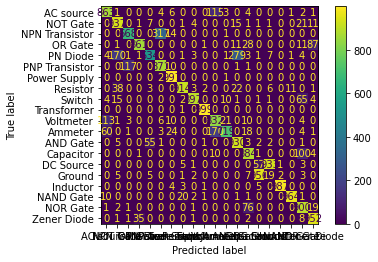

In [37]:
y_pred = voting_max(y_pred_0, y_pred_1, y_pred_2)
print(y_pred.shape)
print(y_label.shape)
#Making the Confusion Matrix
cm = confusion_matrix(y_label, y_pred)
disp = ConfusionMatrixDisplay(cm,display_labels=['AC source','NOT Gate','NPN Transistor','OR Gate','PN Diode','PNP Transistor','Power Supply','Resistor','Switch','Transformer','Voltmeter','Ammeter','AND Gate','Capacitor','DC Source','Ground','Inductor','NAND Gate','NOR Gate','Zener Diode'])

#Accuracy
from sklearn.metrics import accuracy_score
print("Testing accuracy:")
print(accuracy_score(y_label, y_pred))
#F1_score
from sklearn.metrics import f1_score
print("Testing F1-score")
print(f1_score(y_label, y_pred, average = 'macro'))
#Precision
from sklearn.metrics import precision_score
print("Testing Precision:")
print(precision_score(y_label, y_pred, average = 'macro'))
#Recall
from sklearn.metrics import recall_score
print("Testing Recall:")
print(recall_score(y_label, y_pred, average = 'macro'))
plt.figure(figsize=(20,20))
disp.plot()

#### Weighted Voting

Testing accuracy:
0.7621189405297352
Testing F1-score
0.7608084583119055
Testing Precision:
0.7682498244956081
Testing Recall:
0.7622603960396039


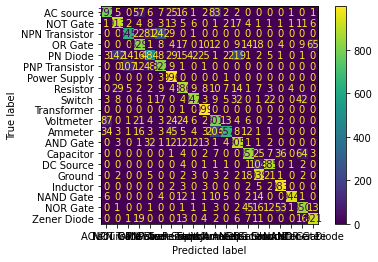

In [38]:
y_pred = voting_weighted(y_pred_0, y_pred_1, y_pred_2)

#Making the Confusion Matrix
cm = confusion_matrix(y_label, y_pred)
disp = ConfusionMatrixDisplay(cm,display_labels=['AC source','NOT Gate','NPN Transistor','OR Gate','PN Diode','PNP Transistor','Power Supply','Resistor','Switch','Transformer','Voltmeter','Ammeter','AND Gate','Capacitor','DC Source','Ground','Inductor','NAND Gate','NOR Gate','Zener Diode'])

#Accuracy
from sklearn.metrics import accuracy_score
print("Testing accuracy:")
print(accuracy_score(y_label, y_pred))
#F1_score
from sklearn.metrics import f1_score
print("Testing F1-score")
print(f1_score(y_label, y_pred, average = 'macro'))
#Precision
from sklearn.metrics import precision_score
print("Testing Precision:")
print(precision_score(y_label, y_pred, average = 'macro'))
#Recall
from sklearn.metrics import recall_score
print("Testing Recall:")
print(recall_score(y_label, y_pred, average = 'macro'))

disp.plot()

#### Groupwise Weighted Voting

In [ ]:
y_pred = voting_group_weighted(y_pred_0, y_pred_1, y_pred_2, y_pred_3, y_pred_4)

#Making the Confusion Matrix
cm = confusion_matrix(y_label, y_pred)
disp = ConfusionMatrixDisplay(cm,display_labels=['1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20'])

#Accuracy
from sklearn.metrics import accuracy_score
print("Testing accuracy:")
print(accuracy_score(y_label, y_pred))
#F1_score
from sklearn.metrics import f1_score
print("Testing F1-score")
print(f1_score(y_label, y_pred, average = 'macro'))
#Precision
from sklearn.metrics import precision_score
print("Testing Precision:")
print(precision_score(y_label, y_pred, average = 'macro'))
#Recall
from sklearn.metrics import recall_score
print("Testing Recall:")
print(recall_score(y_label, y_pred, average = 'macro'))

disp.plot()

#### Mean Weighted Voting

Testing accuracy:
0.7901549225387307
Testing F1-score
0.7882585198905607
Testing Precision:
0.7970865722528505
Testing Recall:
0.7902856435643564


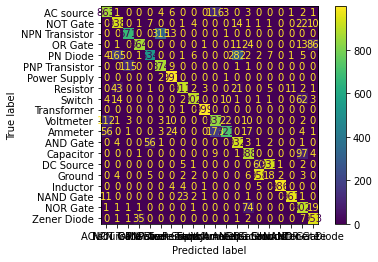

In [12]:
y_pred = voting_mean(Y_pred_0, Y_pred_1, Y_pred_2)

#Making the Confusion Matrix
cm = confusion_matrix(y_label, y_pred)
disp = ConfusionMatrixDisplay(cm,display_labels=['AC source','NOT Gate','NPN Transistor','OR Gate','PN Diode','PNP Transistor','Power Supply','Resistor','Switch','Transformer','Voltmeter','Ammeter','AND Gate','Capacitor','DC Source','Ground','Inductor','NAND Gate','NOR Gate','Zener Diode'])

#Accuracy
from sklearn.metrics import accuracy_score
print("Testing accuracy:")
print(accuracy_score(y_label, y_pred))
#F1_score
from sklearn.metrics import f1_score
print("Testing F1-score")
print(f1_score(y_label, y_pred, average = 'macro'))
#Precision
from sklearn.metrics import precision_score
print("Testing Precision:")
print(precision_score(y_label, y_pred, average = 'macro'))
#Recall
from sklearn.metrics import recall_score
print("Testing Recall:")
print(recall_score(y_label, y_pred, average = 'macro'))

disp.plot()